# Toxic Comments Challenge:
#### By Andreas Nielsen, Aidan Huerta, and Drew Levy
-------



## First lets load and explore the data that we will be using.
For the competition this data set came from the goal of the model is to differentiate between different types of toxic comments from Wikipedia including threats, obscenity, insults, and identity-based hate. If we can detect the difference between these types of toxic comments, websites can use a model such as this to remove types of speech that do not align with their intended use of their services and remove comments that contain hate-speech from their platforms, making the internet a more positive and welcoming space to communicate. 

In [59]:
# Import everything we need for our models
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer

### For the challenge we are provided with the following Train.csv, Test.csv, and Test_labels.csv
-----

In [6]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
test_labels_df = pd.read_csv('test_labels.csv')

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 70)
pd.set_option('display.expand_frame_repr', False)
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print()
print("Below is a small sample of what the data provided to us looks like:")
print(train_df.head())

Train shape: (159571, 8)
Test shape: (153164, 2)

Below is a small sample of what the data provided to us looks like:
                 id                                                           comment_text  toxic  severe_toxic  obscene  threat  insult  identity_hate
0  0000997932d777bf  Explanation\nWhy the edits made under my username Hardcore Metalli...      0             0        0       0       0              0
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm seemingly stuck with....      0             0        0       0       0              0
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It's just that this gu...      0             0        0       0       0              0
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on improvement - I wond...      0             0        0       0       0              0
4  0001d958c54c6e35    You, sir, are my hero. Any chance you remember what page that's on?      0             0        0  

### Data Exploration:
Lets learn more about the provided data. This will give us insight into what the distribution of data is, as well as give us some understanding of what models might end up working well to classify comments into one of the 5 categories or if the comment is not even a toxic comment.

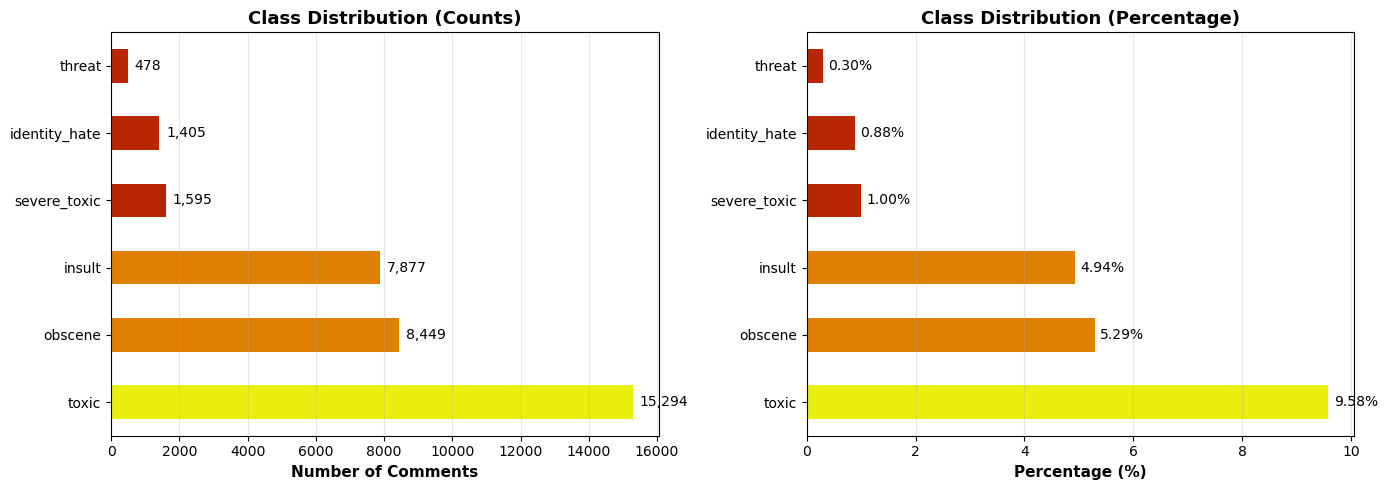

Class Summary
Label                       Count   Percentage       Imbalance
toxic                      15,294        9.58%            1:10
obscene                     8,449        5.29%            1:18
insult                      7,877        4.94%            1:20
severe_toxic                1,595        1.00%           1:100
identity_hate               1,405        0.88%           1:113
threat                        478        0.30%           1:333
Total Samples             159,571
Non-toxic Samples         143,346       89.83%
Toxic Samples              16,225       10.17%


In [28]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

counts = train_df[label_cols].sum().sort_values(ascending=False)
percentages = (counts / len(train_df)) * 100

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

#Plot 1: Class Distribution (Count)
colors = ['#eaf00e' if x > 10000 else '#e08002' if x > 5000 else '#b92602' for x in counts]
counts.plot(kind='barh', ax=ax1, color=colors)
ax1.set_xlabel('Number of Comments', fontsize=11, fontweight='bold')
ax1.set_title('Class Distribution (Counts)', fontsize=13, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

for i, (label, value) in enumerate(counts.items()):
    ax1.text(value + 200, i, f'{value:,}', va='center', fontsize=10)
    
#Plot 2: Class Distribution (Percentages)
percentages.plot(kind='barh', ax=ax2, color=colors)
ax2.set_xlabel('Percentage (%)', fontsize=11, fontweight='bold')
ax2.set_title('Class Distribution (Percentage)', fontsize=13, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

for i, (label, value) in enumerate(percentages.items()):
    ax2.text(value + 0.1, i, f'{value:.2f}%', va='center', fontsize=10)

plt.tight_layout()
plt.show()

print("Class Summary")
print("="*80)
print(f"{'Label':<20} {'Count':>12} {'Percentage':>12} {'Imbalance':>15}")

for label in counts.index:
    count = counts[label]
    pct = percentages[label]
    ratio = int(len(train_df) / count)
    print(f"{label:<20} {count:>12,} {pct:>11.2f}% {'1:'+str(ratio):>15}")
print(f"{'Total Samples':<20} {len(train_df):>12,}")
print(f"{'Non-toxic Samples':<20} {(train_df[label_cols].sum(axis=1) == 0).sum():>12,} " + 
      f"{((train_df[label_cols].sum(axis=1) == 0).sum()/len(train_df)*100):>11.2f}%")
print(f"{'Toxic Samples':<20} {(train_df[label_cols].sum(axis=1) >0).sum():>12,} " + 
      f"{((train_df[label_cols].sum(axis=1) >0).sum()/len(train_df)*100):>11.2f}%")

### Before we begin building our models lets consider some naive approaches for classification
-----
If our models can outperform these naive approaches that means we have learned something meaningful about the data.

* Naive Strategy 1: Awlays Predict 'Not Toxic'
* Naive Strategy 2: Randomly Guess Based on Class Distribution
* Naive Strategy 3: Always Predict Toxic if Contains Profanity


In [51]:
print("Naive Approach #1: Always Predict Not Toxic")
print("-"*70)
print(f"{'Label':<20} {'Accuracy':>12}")

for label in label_cols: 
    accuracy = ((train_df[label] == 0).sum() / len(train_df)) * 100
    roc_auc = 0.5  
    print(f"{label:<20} {accuracy:>11.2f}%")

mean_accuracy = ((train_df[label_cols] == 0).sum().sum() / 
                 (len(train_df) * len(label_cols)) * 100)

print("-"*70)
print(f"{'Mean Accuracy':<20} {mean_accuracy:>11.2f}%")

print("\nNaive Approach #2: Random Guess Based on Class Distribution")
print("-"*70)
print(f"{'Label':<20} {'Exp Accuracy':>15}")

for label in label_cols:
    p = train_df[label].mean()  
    expected_accuracy = (p*p + (1-p)*(1-p)) * 100
    
    print(f"{label:<20} {expected_accuracy:>14.2f}%")

avg_expected_acc = (
    sum([(train_df[label].mean()**2 + (1 - train_df[label].mean())**2) for label in label_cols]) 
    / len(label_cols) * 100
)

print("-"*70)
print(f"{'Mean Expected Accuracy':<20} {avg_expected_acc:>14.2f}%")

print("\nNaive Approach #3: Look for Profanity, classify it as toxic")

url = 'https://www.cs.cmu.edu/~biglou/resources/bad-words.txt'
response = requests.get(url)
bad_words = set(response.text.lower().split('\n'))
bad_words = {word.strip() for word in bad_words if word.strip()}

def contains_profanity(text):
    text_lower = text.lower()
    words_in_text = set(text_lower.split())
    return 1 if (words_in_text & bad_words) else 0

train_df['keyword_prediction'] = train_df['comment_text'].apply(contains_profanity)

print(f"{'Label':<20} {'Accuracy':>12}")
print("-"*70)
accuracies = []
for label in label_cols:
    accuracy = (train_df[label] == train_df['keyword_prediction']).sum() / len(train_df) * 100
    accuracies.append(accuracy)
    print(f"{label:<20} {accuracy:>11.2f}%")
mean_accuracy_keyword = np.mean(accuracies)
print("-"*70)
print(f"{'Mean Accuracy':<20} {mean_accuracy_keyword:>11.2f}%")

Naive Approach #1: Always Predict Not Toxic
----------------------------------------------------------------------
Label                    Accuracy
toxic                      90.42%
severe_toxic               99.00%
obscene                    94.71%
threat                     99.70%
insult                     95.06%
identity_hate              99.12%
----------------------------------------------------------------------
Mean Accuracy              96.33%

Naive Approach #2: Random Guess Based on Class Distribution
----------------------------------------------------------------------
Label                   Exp Accuracy
toxic                         82.67%
severe_toxic                  98.02%
obscene                       89.97%
threat                        99.40%
insult                        90.61%
identity_hate                 98.25%
----------------------------------------------------------------------
Mean Expected Accuracy          93.16%

Naive Approach #3: Look for Profanity, c

### Discusion
Naive Approach #1 performed the best at 96.33% accuracy, however is a very bad model. As it is much more likely for a comment to not be toxic, purely guessing not toxic will equate to being correct most of the time. However when doing this we do no learning.

Naive Approach #2: Randomly guessing based on class distribution gives us 93$ accuracy. As there is a very unlikely chance for a comment to be a threat, severe_toxic, or identity_hate these were very accurate. However, more commonly seen comments including toxic and obscene comments were less accurate.

Naive Approach #3: If we purely classify a comment as toxic given if it contains a profanity performed the worst. However, using this as a preprocessing step and used in a more complex model will allow us to better model our data and get more accurate results.

In [64]:
# Do not include in the report
train_df['total_labels'] = train_df[label_cols].sum(axis=1)

most_toxic = train_df.nlargest(30, 'total_labels')

for idx, (i, row) in enumerate(most_toxic.iterrows(), 1):
    active_labels = [label for label in label_cols if row[label] == 1]
   # print(f"Labels: {', '.join(active_labels)}")
    comment = row['comment_text']
    #print(f"Text: {comment[:500]}")
    #print()



Logistic Regression Accuracy
Label                Accuracy (%)
--------------------------------------------------
toxic                       92.54
severe_toxic                99.35
obscene                     96.05
threat                      99.52
insult                      95.80
identity_hate               98.78
--------------------------------------------------
Mean accuracy: 97.0052


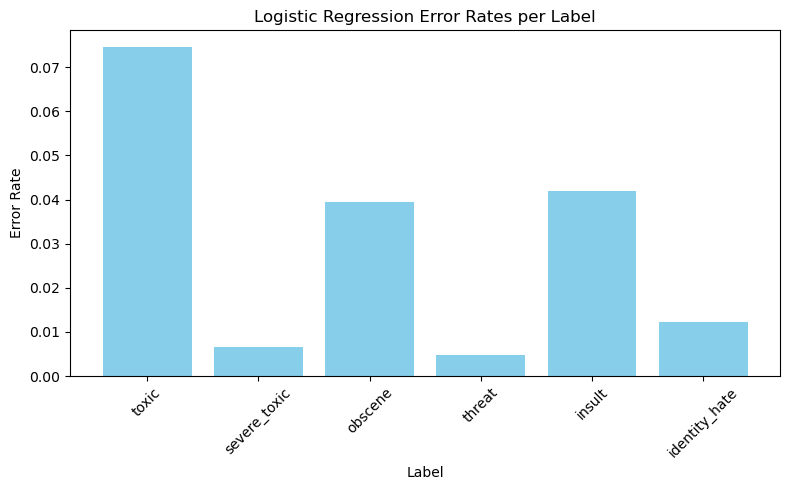

In [69]:
test_df_merged = test_df.merge(test_labels_df, on='id')
test_df_merged = test_df_merged[test_df_merged[label_cols].ge(0).all(axis=1)]

vectorizer = CountVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

models = {}
predictions_test = {}
errors = []

print("\nLogistic Regression Accuracy")
print("=" * 50)
print(f"{'Label':<20} {'Accuracy (%)':>12}")
print("-" * 50)
mean_accuracy =0
for label in label_cols:
    model = LogisticRegression(C=1.0, max_iter=1000)
    model.fit(X_train_vec, y_train[label])
    
    models[label] = model
    predictions_test[label] = model.predict(X_test_vec)
    
    acc = accuracy_score(y_test[label], predictions_test[label]) * 100
    mean_accuracy+=acc
    errors.append(1 - acc/100)
    
    print(f"{label:<20} {acc:>12.2f}")
print("-" * 50)
print(f"Mean accuracy: {mean_accuracy/6:.4f}")
plt.figure(figsize=(8, 5))
plt.bar(label_cols, errors, color='skyblue')
plt.ylabel("Error Rate")
plt.xlabel("Label")
plt.title("Logistic Regression Error Rates per Label")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Discusion

With a mean accuracy of 97% this is better than our naive approach of always guessing